# [BAF627] Portfolio Optimization and Management HW 1

## Install tqdm by following:

!pip install tqdm

# Import modules

In [1]:
import os
# print(os.getcwd())

import pandas as pd
from pandas.tseries.offsets import MonthEnd

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import copy

# https://programmerclick.com/article/4079505481/
from scipy.optimize import minimize

# Read data

In [2]:
msf = pd.read_csv('msf.csv')
msf['mdate'] = pd.to_datetime(msf['mdate'],format='%Y-%m-%d')

msp500 = pd.read_csv('msp500_risk_free.csv')
msp500['mdate'] = pd.to_datetime(msp500['mdate'],format='%Y-%m-%d')

# Basic Parameters

### Standard deviations

In [3]:
mu_msp500 = msp500['spret'].mean()
std_msp500 = msp500['spret'].std()

### Average risk-free rate

In [4]:
rf_all = msp500['rf'].mean()

### Covariance matrix

In [17]:
def get_cov_inv(msf_sample):

    msf_pivot = msf_sample.pivot(index='mdate', columns='permno', values='ret')
    sigma = msf_pivot.cov()
    inv = np.linalg.inv(sigma)
    
    return sigma, inv

### Vector of ones

In [6]:
nfirms = len(msf['permno'].unique())
ones100 = np.ones((nfirms,1))

# 1. Case#2

## 1.a.

In [7]:
def get_parameters(ones, inv, z):

    A = ones.T.dot(inv).dot(ones)

    B = ones.T.dot(inv).dot(z)

    C = z.T.dot(inv).dot(z)

    Delta = A*C-B**2
    
    return A, B, C, Delta

In [23]:
def get_ans1a(mu_p,
              z, A, B, C, Delta, inv, sigma, ones,
             ):
    '''Calculate the closed-form solution of Case 2 for given target portfolio retun mu_p'''
    
    gamma1a = (mu_p*A-B)/Delta
    lambda1a = (C-mu_p*B)/Delta
    w1a = inv.dot(lambda1a*ones+gamma1a*z)

    mu_port1a = float(w1a.T.dot(z)[0][0])
    std_port1a = float(w1a.T.dot(sigma).dot(w1a)[0][0])**(1/2)
    
    return w1a, mu_port1a, std_port1a

### Average returns of given sample

In [9]:
# We will save weights for problems on the weights
weights = msf.groupby(['permno', 'ticker', 'comnam'])['ret'].mean().reset_index().set_index(['permno'])

In [10]:
z1a = weights['ret'].values.reshape(-1,1)

In [18]:
sigma1a, inv1a = get_cov_inv(msf)

In [19]:
A1a, B1a, C1a, Delta1a = get_parameters(ones100, inv1a, z1a)

In [24]:
step = 0.001 # 10bp

min_ret = -0.1 # multiply 100 to get a percent unit.
max_ret = 0.1

list_ans1a = []
for mu_p in np.arange(min_ret,max_ret+step,step):
    
    _, mu_port1a, std_port1a = get_ans1a(mu_p, z1a, A1a, B1a, C1a, Delta1a, inv1a, sigma1a, ones100)
    
    tmp_ans1a = pd.DataFrame([[mu_port1a, std_port1a]],columns=['port_ret', 'port_std'])
    
    list_ans1a.append(tmp_ans1a)

In [25]:
ans1a = pd.concat(list_ans1a).reset_index(drop=True)
ans1a.sort_values(['port_ret'],inplace=True)
ans1a.reset_index(drop=True,inplace=True)

GMVP Std: 2.390% 
GMVP Return: 1.172%


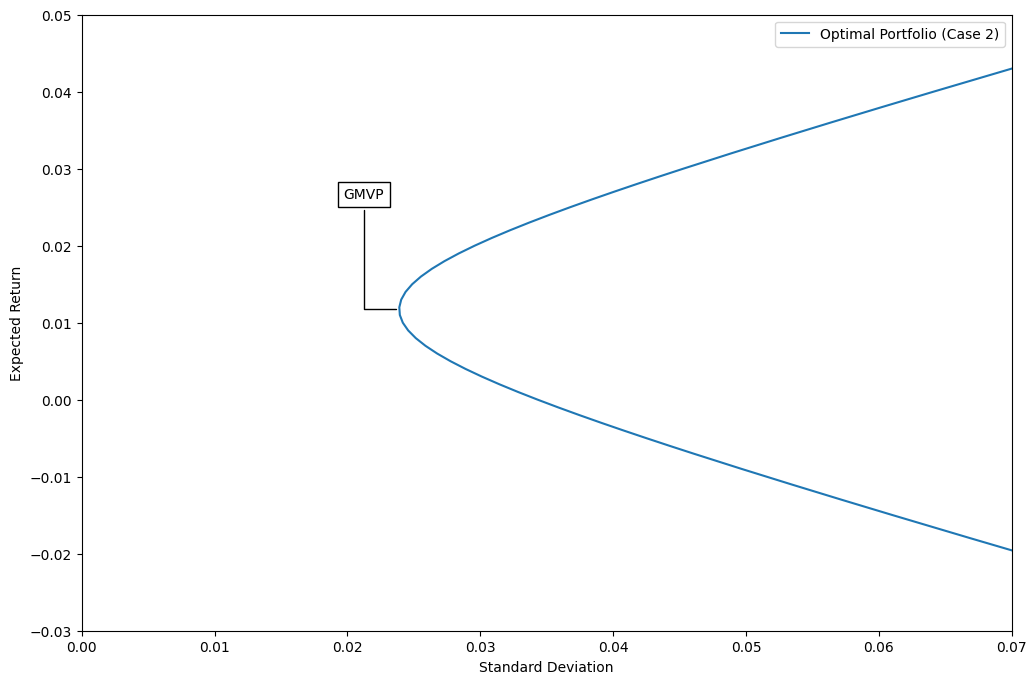

In [27]:
## fig

fig, ax = plt.subplots(1,1,figsize=(12,8))

ans1a.plot(x='port_std', y='port_ret', ax=ax, legend=False)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.set_xlim(0,0.07)
ax.set_ylim(-0.03,0.05)

ax.set_xlim(0)

w_gmvp = inv1a.dot(ones100)/(ones100.T.dot(inv1a).dot(ones100))
w_gmvp.sum()

mu_gmvp = w_gmvp.T.dot(z1a)
std_gmvp = (w_gmvp.T.dot(sigma1a).dot(w_gmvp))**(0.5)

# ax.axvline(std_gmvp,color='black')
arrowprops=dict(
    arrowstyle='-',
    connectionstyle="angle,angle A=90, angle B=0")

bbox=dict(fc='1')

ax.annotate(
    "GMVP",
    xy=(std_gmvp,mu_gmvp),
    xytext=(-40,80), #위치
    textcoords='offset points',
    arrowprops=arrowprops, 
    bbox=bbox
)

print('GMVP Std: {:.3f}%'.format(100*float(std_gmvp[0][0])), '\nGMVP Return: {:.3f}%'.format(100*float(mu_gmvp[0][0])))
ax.legend(['Optimal Portfolio (Case 2)'])

### Annualizing also works

## Vectorized solution

In [28]:
mu_v = np.arange(min_ret,max_ret+step,step).reshape(-1,1)
gamma1_v = (mu_v*A1a-B1a)/Delta1a
lambda1_v = (C1a-mu_v*B1a)/Delta1a
w1v = inv1a.dot(ones100.dot(lambda1_v.T)+z1a.dot(gamma1_v.T))

port_ret_v = w1v.T.dot(z1a)
port_std_v = (np.diag(w1v.T.dot(sigma1a).dot(w1v))**(1/2)).reshape(-1,1)

ans1_v = pd.DataFrame(np.c_[port_ret_v, port_std_v],columns=['ret', 'std'])

ans1_v.sort_values(['ret'],inplace=True)
ans1_v.reset_index(drop=True,inplace=True)

In [29]:
port_ret_v = w1v.T.dot(z1a)
port_std_v = (np.diag(w1v.T.dot(sigma1a).dot(w1v))**(1/2)).reshape(-1,1)

In [30]:
ans1_v = pd.DataFrame(np.c_[port_ret_v, port_std_v],columns=['ret', 'std'])

In [31]:
ans1_v.sort_values(['ret'],inplace=True)
ans1_v.reset_index(drop=True,inplace=True)

<Axes: xlabel='std'>

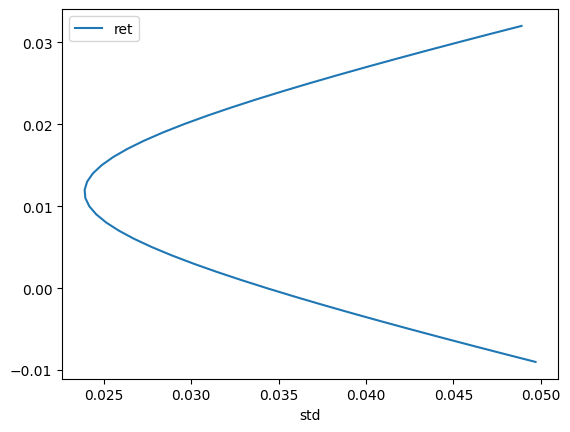

In [32]:
ans1_v[ans1_v['std']<0.05].set_index(['std']).plot()

## 1.b.

In [33]:
mu_msp500

0.007691879732135416

In [34]:
w1b, mu1b, std1b = get_ans1a(mu_msp500, z1a, A1a, B1a, C1a, Delta1a, inv1a, sigma1a, ones100)

In [35]:
weights['w1b'] = w1b

In [81]:
weights

,ticker,comnam,ret,w1b,w2b,w3b
permno,,,,,,
10104,ORCL,ORACLE CORP,0.020770,0.007895,0.008569,3.067343e-03
10107,MSFT,MICROSOFT CORP,0.021537,0.041989,0.039155,3.182703e-02
10145,HON,HONEYWELL INTERNATIONAL INC,0.013530,-0.070917,-0.009325,0.000000e+00
10696,FISV,FISERV INC,0.016910,-0.033187,0.019559,1.074382e-18
11308,KO,COCA COLA CO,0.010164,0.014292,-0.028082,0.000000e+00
...,...,...,...,...,...,...
75825,EOG,EOG RESOURCES INC,0.015138,-0.029889,0.006637,6.075079e-19
85631,ADSK,AUTODESK INC,0.018574,-0.017126,-0.003306,1.232698e-18
87055,COST,COSTCO WHOLESALE CORP NEW,0.015851,0.066514,-0.008632,2.497477e-18


In [36]:
(weights.loc[[22592,59408,61241,14593,43449]].reset_index().set_index(['permno', 'ticker', 'comnam'])[['w1b']]*100).round(3)

,,,w1b
permno,ticker,comnam,
22592,MMM,3M CO,13.715
59408,BAC,BANK OF AMERICA CORP,-1.781
61241,AMD,ADVANCED MICRO DEVICES INC,-2.418
14593,AAPL,APPLE INC,-0.151
43449,MCD,MCDONALDS CORP,-0.403


## 1.c. 

In [37]:
ans1c = pd.DataFrame([[(mu1b-rf_all)*12*100, (mu_msp500-rf_all)*12*100],
                      [std1b*np.sqrt(12)*100, std_msp500*np.sqrt(12)*100],
                      [(mu1b-rf_all)/std1b*np.sqrt(12), (mu_msp500-rf_all)/std_msp500*np.sqrt(12)],
                     ],
                     columns=['Optimal Portfolio (Case 2)', 'S&P 500'],
                     index=['Excess Return (%)',
                            'Volatility (%)',
                            'Sharpe Ratio',
                           ],
                    )

In [38]:
ans1c[['S&P 500',
       'Optimal Portfolio (Case 2)',
      ]]

,S&P 500,Optimal Portfolio (Case 2)
Excess Return (%),6.700256,6.700256
Volatility (%),14.578627,8.784146
Sharpe Ratio,0.459594,0.762767


## 1.d.

In [39]:
msf['w1b'] = msf['permno'].map(weights['w1b'])
msf['wret1b'] = msf['ret']*msf['w1b']

In [40]:
ans1d = msf.groupby(['mdate'])['wret1b'].sum()

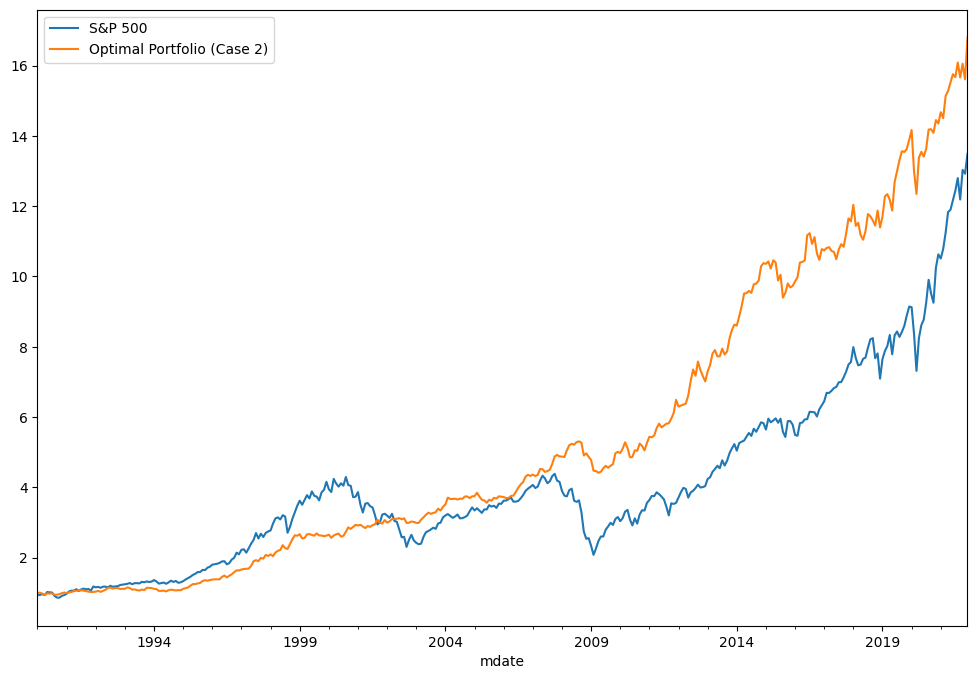

In [41]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

msp500.set_index(['mdate'])['spret'].add(1).cumprod().plot()
ans1d.add(1).cumprod().plot()

ax.legend(['S&P 500', 
           'Optimal Portfolio (Case 2)', ],)

# 2.

## 2.a.

In [45]:
def get_ans2a(mu_p,
              z,A,B,C,rf,inv,sigma,ones,
             ):
    '''Calculate the closed-form solution of Case 2 for given target portfolio retun mu_p'''
    
    gamma2a = (mu_p-rf)/(C-2*rf*B+rf**2*A)
    w2a = gamma2a*inv.dot(z-rf*ones)

    mu2a = float(w2a.T.dot(z)[0][0]+(1-w2a.T.dot(ones)[0][0])*rf)
    std2a = float(w2a.T.dot(sigma).dot(w2a)[0][0])**(1/2)
    
    return w2a, mu2a, std2a

In [46]:
step = 0.001 # 10bp

max_ret = 0.1

list_ans2a = []

for mu_p2a in list(np.arange(rf_all,max_ret+step,step))+[rf_all]:
    _, mu2a, std2a = get_ans2a(mu_p2a, z1a, A1a,B1a,C1a,rf_all,inv1a,sigma1a,ones100,)
    
    tmp_ans2a = pd.DataFrame([[mu2a, std2a]],columns=['port_ret', 'port_std'])
    
    list_ans2a.append(tmp_ans2a)

In [47]:
ans2a = pd.concat(list_ans2a).reset_index(drop=True)
ans2a.sort_values(['port_std', 'port_ret'],inplace=True)
ans2a.reset_index(drop=True,inplace=True)

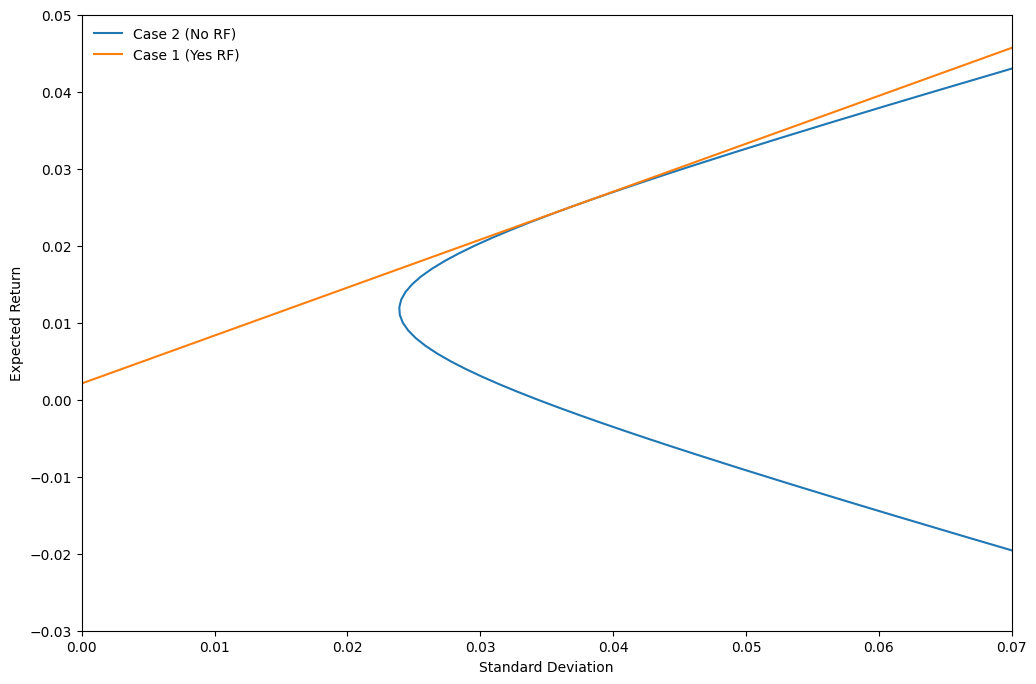

In [48]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

ans1a.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans2a.plot(x='port_std', y='port_ret', ax=ax, legend=False)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.set_xlim(0,0.07)
ax.set_ylim(-0.03,0.05)

ax.set_xlim(0)

slope = np.sqrt(C1a-2*rf_all*B1a+rf_all**2*A1a)

rf_all

slope*np.sqrt(12)

tmp_x = np.linspace(0,0.07,101)
# ax.plot(tmp_x,tmp_x*slope[0,0]+rf)

ax.legend(['Case 2 (No RF)', 'Case 1 (Yes RF)'],frameon=False,loc='upper left')

## 2.b.

In [49]:
w2b, mu2b, std2b = get_ans2a(mu_msp500, z1a, A1a,B1a,C1a,rf_all,inv1a,sigma1a,ones100,)

In [50]:
weights['w2b'] = w2b

In [141]:
(weights.loc[[22592,59408,61241,14593,43449]].reset_index().set_index(['permno', 'ticker', 'comnam'])[['w2b']]*100).round(3)

,,,w2b
permno,ticker,comnam,
22592,MMM,3M CO,2.401
59408,BAC,BANK OF AMERICA CORP,-0.894
61241,AMD,ADVANCED MICRO DEVICES INC,-0.230
14593,AAPL,APPLE INC,1.088
43449,MCD,MCDONALDS CORP,1.116


## 2.c.

In [52]:
ans2c = pd.DataFrame([[(mu2b-rf_all)*12*100],
                      [std2b*np.sqrt(12)*100],
                      [(mu2b-rf_all)/std2b*np.sqrt(12)],
                     ],
                     columns=['Optimal Portfolio (Case 1)'],
                     index=['Excess Return (%)',
                            'Volatility (%)',
                            'Sharpe Ratio',
                           ],
                    )
ans_summary_stat = ans1c.copy()
ans_summary_stat['Optimal Portfolio (Case 1)'] = ans2c['Optimal Portfolio (Case 1)']

In [147]:
ans_summary_stat[['S&P 500',
                  'Optimal Portfolio (Case 1)', 
                  'Optimal Portfolio (Case 2)'
                  ]]

,S&P 500,Optimal Portfolio (Case 1),Optimal Portfolio (Case 2)
Excess Return (%),6.700256,6.700256,6.700256
Volatility (%),14.578627,3.106376,8.784146
Sharpe Ratio,0.459594,2.156936,0.762767


## 2.d.

In [54]:
msf['w2b'] = msf['permno'].map(weights['w2b'])
msf['wret2b'] = msf['ret']*msf['w2b']

$r_p = w\cdot r_{risky}+(1-w)\cdot r_f$

In [55]:
1-weights['w2b'].sum(0)

0.7577421381538398

In [56]:
ans2d = msf.groupby(['mdate'])['wret2b'].sum()+(1-msf.groupby(['mdate'])['w2b'].sum())*msp500.set_index(['mdate'])['rf']

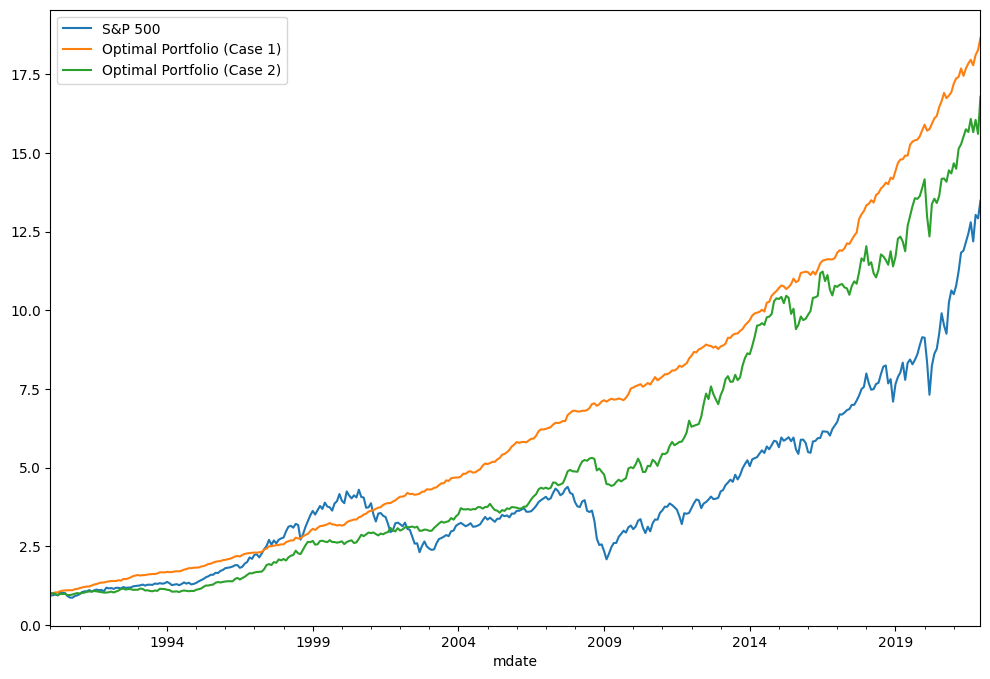

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

msp500.set_index(['mdate'])['spret'].add(1).cumprod().plot()
ans2d.add(1).cumprod().plot()
ans1d.add(1).cumprod().plot()

ax.legend(['S&P 500', 
           'Optimal Portfolio (Case 1)', 
           'Optimal Portfolio (Case 2)',
          ],)

# 3.

## 3.a.

In [58]:
min_vol = 0
max_vol = 0.2

step2 = 0.0005

- w: [rf, r_1, r_2, ..., r_n]

- w[0] : weight on the risk-free

- w[1:] : weights on the risky

In [59]:
def minimizing_vol(w):
    port_vol = w[1:].T.dot(sigma1a).dot(w[1:])
    return port_vol

In [60]:
def constraint_weight_sum(w):
    return sum(w)-1

def constraint_target_ret(target_port_ret):
    def constraint_target_ret_(w):
        ret_diff = w[1:].T.dot(z1a)+w[0]*rf_all-target_port_ret
        return ret_diff
    return constraint_target_ret_

In [61]:
eq_con_sum_w = {'type': 'eq', 'fun': constraint_weight_sum}

In [62]:
b0 = (None,None) ## no constraint for lending/borrowing
b = (0,None) ## risky asset should not be shorted. None means there is no upper bound. Greater than 1 means borrowed money is invested in some stocks

bnds = [b0]+[b for i in range(nfirms)]

In [63]:
nassets = nfirms+1

w0 = list((np.ones([nassets,1])/nassets).reshape(-1))

In [64]:
list_ans3a = []

for mu_p3a in tqdm(np.linspace(rf_all,max_ret,201)):
    
    eq_con_target_ret = {'type': 'eq', 'fun': constraint_target_ret(mu_p3a)}
    cons = [eq_con_sum_w]+[eq_con_target_ret]
    
    sol3a = minimize(minimizing_vol, 
                     w0,
                     method='SLSQP', 
                     constraints=cons, 
                     bounds=bnds,
                     options={'maxiter':10000},
                     tol=1e-12
                    )
    if not sol3a.success:
        print('Fail to converge')
        
    w3a = sol3a.x
    mu3a = (w3a[0]*rf_all+w3a[1:].dot(z1a))[0]
    std3a = (w3a[1:].T.dot(sigma1a).dot(w3a[1:]))**(1/2)
    
    tmp_ans3a = pd.DataFrame([[mu3a, std3a]],columns=['port_ret', 'port_std'])
    
    list_ans3a.append(tmp_ans3a)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [03:46<00:00,  1.13s/it]


In [65]:
ans3a = pd.concat(list_ans3a).reset_index(drop=True)
ans3a.sort_values(['port_std'],inplace=True)
ans3a.sort_values(['port_ret'],inplace=True)

In [80]:
ans3a.to_csv('ans3a.csv')

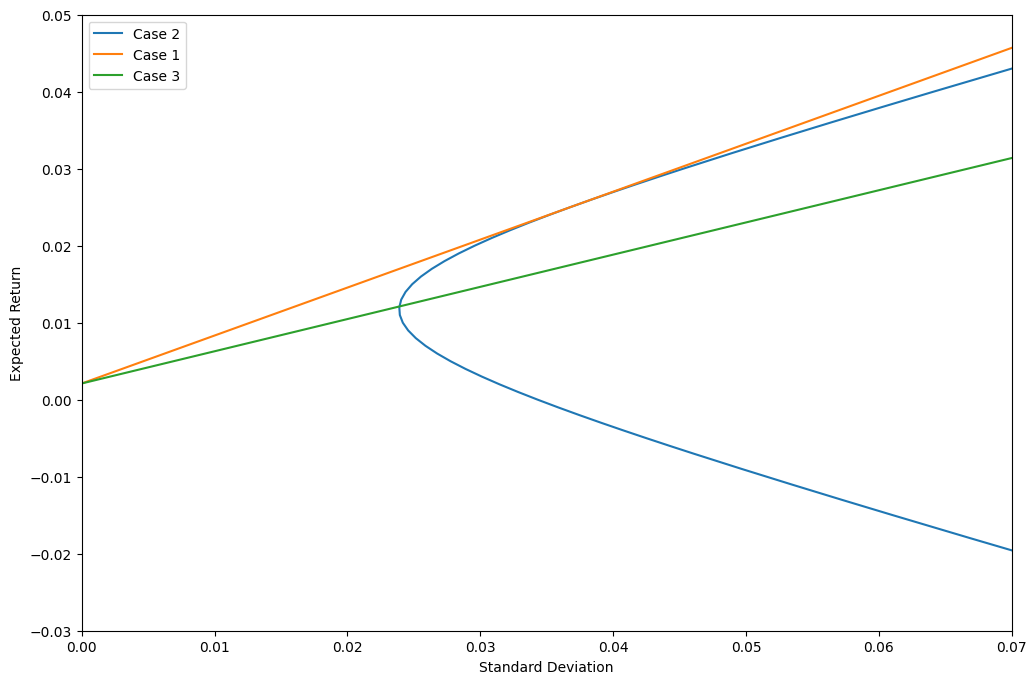

In [66]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

ans1a.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans2a.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans3a.plot(x='port_std',y='port_ret',ax=ax,legend=False)

ax.set_xlim(0,0.07)
ax.set_ylim(-0.03,0.05)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.legend(['Case 2', 'Case 1', 'Case 3'])

## 3.b.

In [67]:
eq_con_target_ret = {'type': 'eq', 'fun': constraint_target_ret(mu_msp500)}
cons = [eq_con_sum_w]+[eq_con_target_ret]

sol3b = minimize(minimizing_vol, 
                 w0,
                 method='SLSQP', 
                 constraints=cons, 
                 bounds=bnds,
                 options={'maxiter':10000},
                 tol=1e-12
                )
if not sol3b.success:
    print('Fail to converge')

w3b = sol3b.x
mu3b = (w3b[0]*rf_all+w3b[1:].dot(z1a))[0]
std3b = (w3b[1:].T.dot(sigma1a).dot(w3b[1:]))**(1/2)

In [68]:
weights['w3b'] = w3b[1:]

In [144]:
1-weights['w3b'].sum(0)

0.641003334692491

In [143]:
(weights.loc[[22592,59408,61241,14593,43449]].reset_index().set_index(['permno', 'ticker', 'comnam'])[['w3b']]*100).round(3)

,,,w3b
permno,ticker,comnam,
22592,MMM,3M CO,0.000
59408,BAC,BANK OF AMERICA CORP,0.000
61241,AMD,ADVANCED MICRO DEVICES INC,0.000
14593,AAPL,APPLE INC,1.363
43449,MCD,MCDONALDS CORP,0.000


## 3.c.

In [70]:
ans3c = pd.DataFrame([[(mu3b-rf_all)*12*100],
                      [std3b*np.sqrt(12)*100],
                      [(mu3b-rf_all)/std3b*np.sqrt(12)],
                     ],
                     columns=['Optimal Portfolio (Case 3)'],
                     index=['Excess Return (%)',
                            'Volatility (%)',
                            'Sharpe Ratio',
                           ],
                    )

ans_summary_stat['Optimal Portfolio (Case 3)'] = ans3c['Optimal Portfolio (Case 3)']

In [146]:
ans_summary_stat[['S&P 500',
                  'Optimal Portfolio (Case 2)', 
                  'Optimal Portfolio (Case 1)', 
                  'Optimal Portfolio (Case 3)', 
                  ]]

,S&P 500,Optimal Portfolio (Case 2),Optimal Portfolio (Case 1),Optimal Portfolio (Case 3)
Excess Return (%),6.700256,6.700256,6.700256,6.700256
Volatility (%),14.578627,8.784146,3.106376,4.624338
Sharpe Ratio,0.459594,0.762767,2.156936,1.448911


## 3.d.

In [72]:
msf['w3b'] = msf['permno'].map(weights['w3b'])
msf['wret3b'] = msf['ret']*msf['w3b']

$r_p = w\cdot r_{risky}+(1-w)\cdot r_f$

In [73]:
ans3d = msf.groupby(['mdate'])['wret3b'].sum()+(1-msf.groupby(['mdate'])['w3b'].sum())*msp500.set_index(['mdate'])['rf']

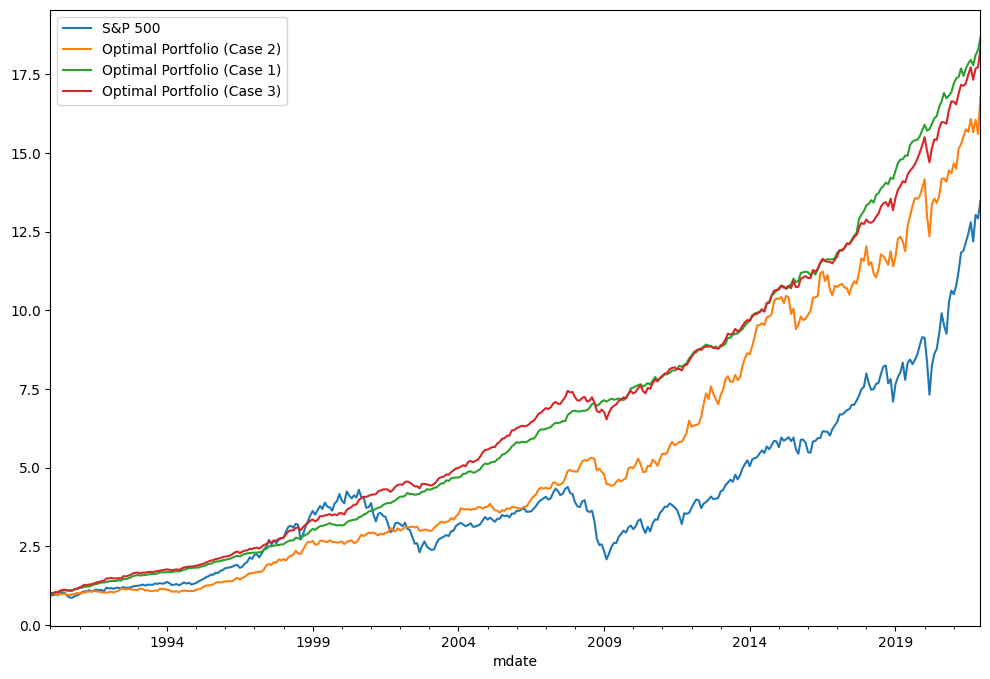

In [74]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

msp500.set_index(['mdate'])['spret'].add(1).cumprod().plot()
ans1d.add(1).cumprod().plot()
ans2d.add(1).cumprod().plot()
ans3d.add(1).cumprod().plot()

ax.legend(['S&P 500',
           'Optimal Portfolio (Case 2)', 
           'Optimal Portfolio (Case 1)', 
           'Optimal Portfolio (Case 3)', 
          ],)

# 4.

## 4.a.

In [75]:
def minimizing_vol_no_rf(w):
    port_vol = w.T.dot(sigma1a).dot(w)
    return port_vol

def constraint_target_ret_no_rf(port_ret):
    def constraint_target_ret_(w):
        ret_diff = w.T.dot(z1a)-port_ret
        return ret_diff
    return constraint_target_ret_

In [76]:
eq_con_sum_w4a = {'type': 'eq', 'fun': constraint_weight_sum}

In [77]:
b4a = (0,1) ## risky asset should not be shorted. There is no lending from risk-free

bnds4a = [b4a for i in range(nfirms)]

In [78]:
w04a = list((np.ones([nfirms,1])/nfirms).reshape(-1))

In [79]:
list_ans4a = []

min_vol = 0
max_vol = 0.2

step2 = 0.0005

## Since we cannot short or borrowing from risk-free, the portfolio return should be between the minimum and maximum of the returns
for mu_p4a in tqdm(np.linspace(min(z1a),max(z1a),201)):
    
    eq_con_target_ret_no_rf = {'type': 'eq', 'fun': constraint_target_ret_no_rf(mu_p4a)}
    cons4a = [eq_con_sum_w4a]+[eq_con_target_ret_no_rf]
    
    sol4a = minimize(minimizing_vol_no_rf, 
                     w04a, 
                     method='SLSQP', 
                     constraints=cons4a, 
                     bounds=bnds4a,
                     tol=1e-12,
                     options={'maxiter':10000}
                    )
    
    if not sol4a.success:
        print('Fail to converge')
        
    w4a = sol4a.x
    mu4a = (w4a.dot(z1a))[0]
    std4a = (w4a.T.dot(sigma1a).dot(w4a))**(1/2)
    
    tmp_ans4a = pd.DataFrame([[mu4a, std4a]],columns=['port_ret', 'port_std'])
    
    list_ans4a.append(tmp_ans4a)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [02:43<00:00,  1.23it/s]


In [82]:
ans4a = pd.concat(list_ans4a).reset_index(drop=True)
ans4a.sort_values(['port_ret'],inplace=True)

In [83]:
ans4a.to_csv('ans4a.csv')

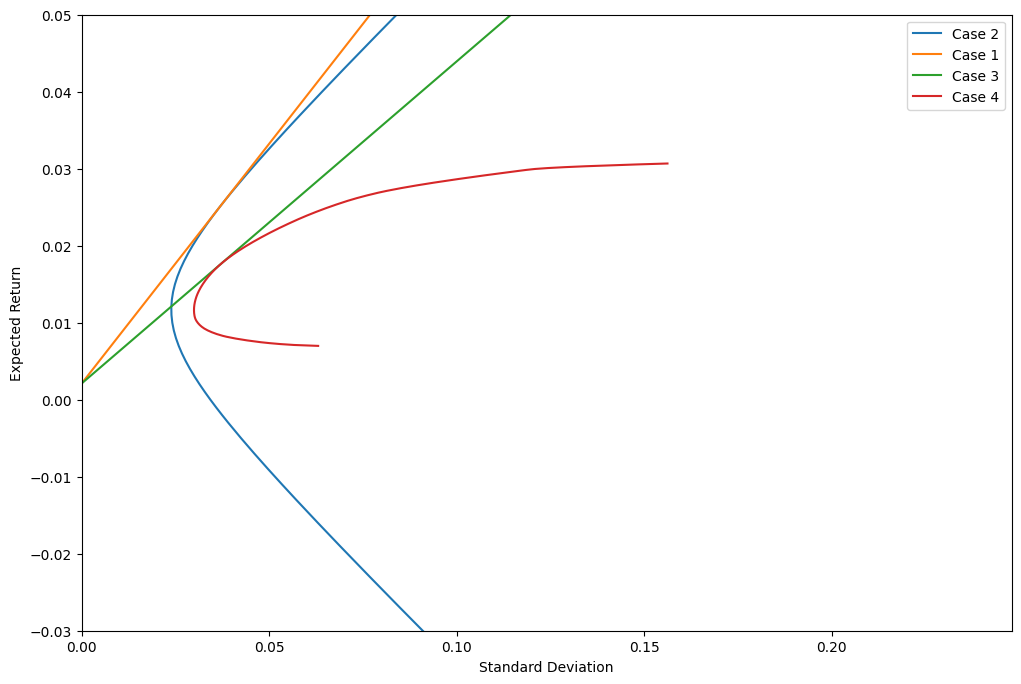

In [84]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

ans1a.plot(x='port_std',y='port_ret',ax=ax,legend=False)
ans2a.plot(x='port_std',y='port_ret',ax=ax,legend=False)
ans3a.plot(x='port_std',y='port_ret',ax=ax,legend=False)
ans4a.plot(x='port_std',y='port_ret',ax=ax,legend=False)

ax.set_xlim(0,)
ax.set_ylim(-0.03,0.05)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.legend(['Case 2', 'Case 1', 'Case 3', 'Case 4'])

## 4.b.

In [85]:
eq_con_target_ret_no_rf4b = {'type': 'eq', 'fun': constraint_target_ret_no_rf(mu_msp500)}
cons4b = [eq_con_sum_w4a]+[eq_con_target_ret_no_rf4b]

sol4b = minimize(minimizing_vol_no_rf, 
                 w04a,
                 method='SLSQP', 
                 constraints=cons4b, 
                 bounds=bnds4a,
                 tol=1e-12,
                 options={'maxiter':10000}
                )
if not sol4b.success:
    print('Fail to converge')

w4b = sol4b.x
mu4b = (w4b.dot(z1a))[0]
std4b = (w4b.T.dot(sigma1a).dot(w4b))**(1/2)

In [86]:
weights['w4b'] = w4b

In [149]:
(weights.loc[[22592,59408,61241,14593,43449]].reset_index().set_index(['permno', 'ticker', 'comnam'])[['w4b']]*100)

,,,w4b
permno,ticker,comnam,
22592,MMM,3M CO,0.000000e+00
59408,BAC,BANK OF AMERICA CORP,0.000000e+00
61241,AMD,ADVANCED MICRO DEVICES INC,2.946364e-16
14593,AAPL,APPLE INC,5.367768e-16
43449,MCD,MCDONALDS CORP,0.000000e+00


## 4.c.

In [88]:
ans4c = pd.DataFrame([[(mu4b-rf_all)*12*100],
                      [std4b*np.sqrt(12)*100],
                      [(mu4b-rf_all)/std4b*np.sqrt(12)],
                     ],
                     columns=['Optimal Portfolio (Case 4)'],
                     index=['Excess Return (%)',
                            'Volatility (%)',
                            'Sharpe Ratio',
                           ],
                    )

ans_summary_stat['Optimal Portfolio (Case 4)'] = ans4c['Optimal Portfolio (Case 4)']

In [89]:
ans_summary_stat[['S&P 500',
                  'Optimal Portfolio (Case 2)', 
                  'Optimal Portfolio (Case 1)', 
                  'Optimal Portfolio (Case 3)', 
                  'Optimal Portfolio (Case 4)', 
                  ]]

,S&P 500,Optimal Portfolio (Case 2),Optimal Portfolio (Case 1),Optimal Portfolio (Case 3),Optimal Portfolio (Case 4)
Excess Return (%),6.700256,6.700256,6.700256,6.700256,6.700256
Volatility (%),14.578627,8.784146,3.106376,4.624338,15.342655
Sharpe Ratio,0.459594,0.762767,2.156936,1.448911,0.436708


## 4.d.

In [90]:
msf['w4b'] = msf['permno'].map(weights['w4b'])
msf['wret4b'] = msf['ret']*msf['w4b']

In [91]:
ans4d = msf.groupby(['mdate'])['wret4b'].sum()

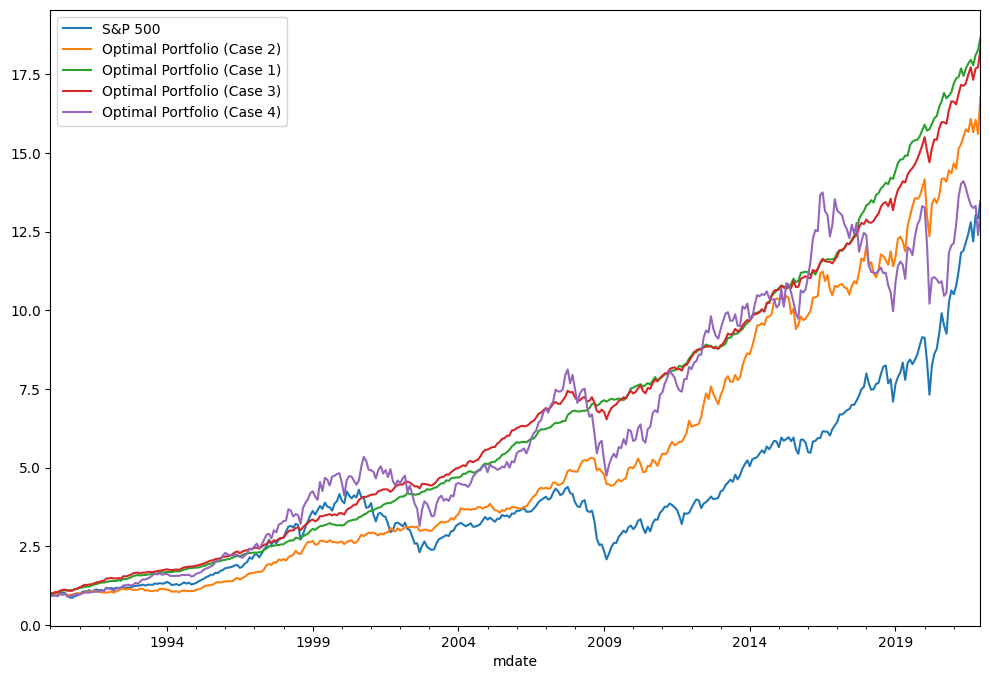

In [92]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

msp500.set_index(['mdate'])['spret'].add(1).cumprod().plot()

ans1d.add(1).cumprod().plot()
ans2d.add(1).cumprod().plot()
ans3d.add(1).cumprod().plot()
ans4d.add(1).cumprod().plot()


ax.legend(['S&P 500',
           'Optimal Portfolio (Case 2)', 
           'Optimal Portfolio (Case 1)', 
           'Optimal Portfolio (Case 3)', 
           'Optimal Portfolio (Case 4)', 
          ],)

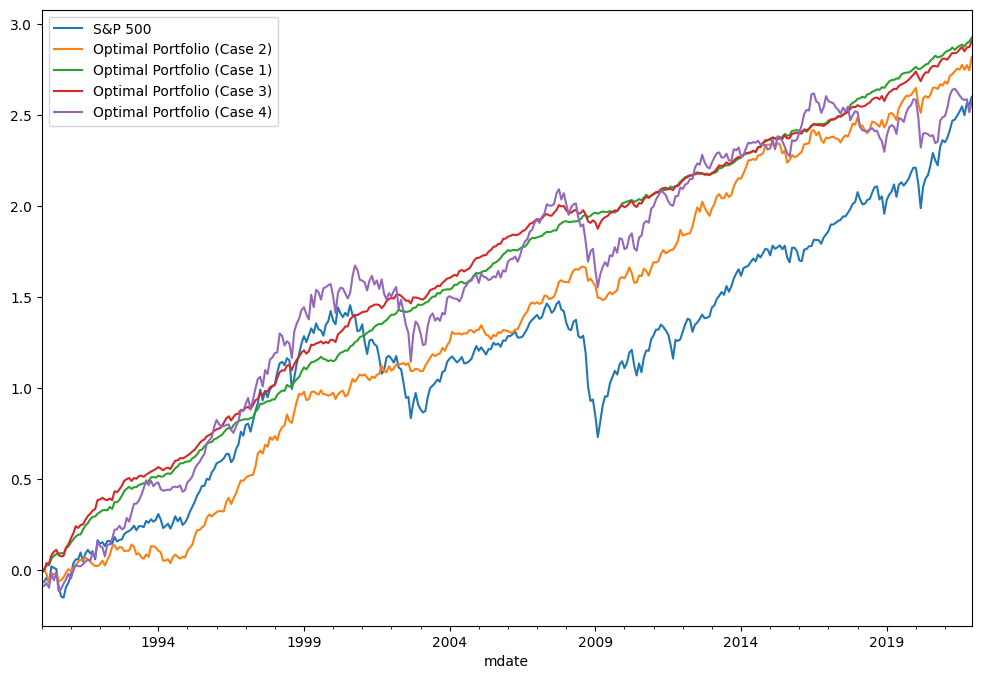

In [93]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

msp500.set_index(['mdate'])['spret'].apply(lambda x: np.log(1+x)).cumsum().plot()

ans1d.apply(lambda x: np.log(1+x)).cumsum().plot()
ans2d.apply(lambda x: np.log(1+x)).cumsum().plot()
ans3d.apply(lambda x: np.log(1+x)).cumsum().plot()
ans4d.apply(lambda x: np.log(1+x)).cumsum().plot()


ax.legend(['S&P 500',
           'Optimal Portfolio (Case 2)', 
           'Optimal Portfolio (Case 1)', 
           'Optimal Portfolio (Case 3)', 
           'Optimal Portfolio (Case 4)', 
          ],)

In [139]:
weights[['ticker','w1b', 'w2b', 'w3b', 'w4b']].to_excel('Weights.xlsx')

# 5.

## 5.a.

## Randomly select 10 stocks.

In [95]:
np.random.seed(0)
random_stocks_index = np.random.choice(100,10,replace=False)

In [96]:
random_stocks_index

array([26, 86,  2, 55, 75, 93, 16, 73, 54, 95])

In [97]:
random_stocks = weights.iloc[random_stocks_index]

In [98]:
random_stocks

,ticker,comnam,ret,w1b,w2b,w3b,w4b
permno,,,,,,,
18542,CAT,CATERPILLAR INC,0.014576,-0.008659,0.029061,0.000000e+00,5.754993e-18
66181,HD,HOME DEPOT INC,0.018281,-0.041751,0.021505,2.895264e-19,8.306363e-19
10145,HON,HONEYWELL INTERNATIONAL INC,0.013530,-0.070917,-0.009325,0.000000e+00,0.000000e+00
47896,JPM,JPMORGAN CHASE & CO,0.014259,0.041126,0.040353,1.169170e-19,1.142143e-18
61399,LOW,LOWES COMPANIES INC,0.020321,-0.013991,-0.018885,7.815997e-19,0.000000e+00
75186,SCHW,SCHWAB CHARLES CORP NEW,0.021624,-0.052622,0.018552,2.860324e-19,0.000000e+00
14593,AAPL,APPLE INC,0.025045,-0.001513,0.010881,1.362713e-02,5.367768e-18
60871,ADI,ANALOG DEVICES INC,0.020205,-0.006268,0.000123,0.000000e+00,0.000000e+00
46886,KLAC,K L A CORP,0.024020,-0.029053,-0.014792,0.000000e+00,2.466110e-17


In [99]:
msf5a = msf[msf['permno'].apply(lambda x: x in random_stocks.index)].copy()

In [100]:
z5a = msf5a.groupby(['permno'])['ret'].mean().values.reshape(-1,1)

### Covariance matrix

In [101]:
sigma5a, inv5a = get_cov_inv(msf5a)

### Vector of ones

In [102]:
nfirms5a = len(msf5a['permno'].unique())
ones5a = np.ones((nfirms5a,1))

In [103]:
A5a, B5a, C5a, Delta5a = get_parameters(ones5a, inv5a, z5a)

In [104]:
step = 0.001 # 10bp

min_ret = -0.1 # multiply 100 to get a percent unit.
max_ret = 0.1

list_ans5a_case2 = []
list_ans5a_case1 = []
for mu_p in np.arange(min_ret,max_ret+step,step):
    
    _, mu_port5a_case2, std_port5a_case2 = get_ans1a(mu_p, z5a, A5a, B5a, C5a, Delta5a, inv5a, sigma5a,ones5a)
    tmp_ans5a_case2 = pd.DataFrame([[mu_port5a_case2, std_port5a_case2]],columns=['port_ret', 'port_std'])
    list_ans5a_case2.append(tmp_ans5a_case2)
    
for mu_p in np.arange(rf_all,max_ret+step,step):
    
    _, mu_port5a_case1, std_port5a_case1 = get_ans2a(mu_p, z5a, A5a,B5a,C5a,rf_all,inv5a,sigma5a,ones5a,)
    tmp_ans5a_case1 = pd.DataFrame([[mu_port5a_case1, std_port5a_case1]],columns=['port_ret', 'port_std'])
    list_ans5a_case1.append(tmp_ans5a_case1)

In [105]:
ans5a_case2 = pd.concat(list_ans5a_case2).reset_index(drop=True)
ans5a_case2.sort_values(['port_ret'],inplace=True)
ans5a_case2.reset_index(drop=True,inplace=True)

ans5a_case1 = pd.concat(list_ans5a_case1).reset_index(drop=True)
ans5a_case1.sort_values(['port_ret'],inplace=True)
ans5a_case1.reset_index(drop=True,inplace=True)

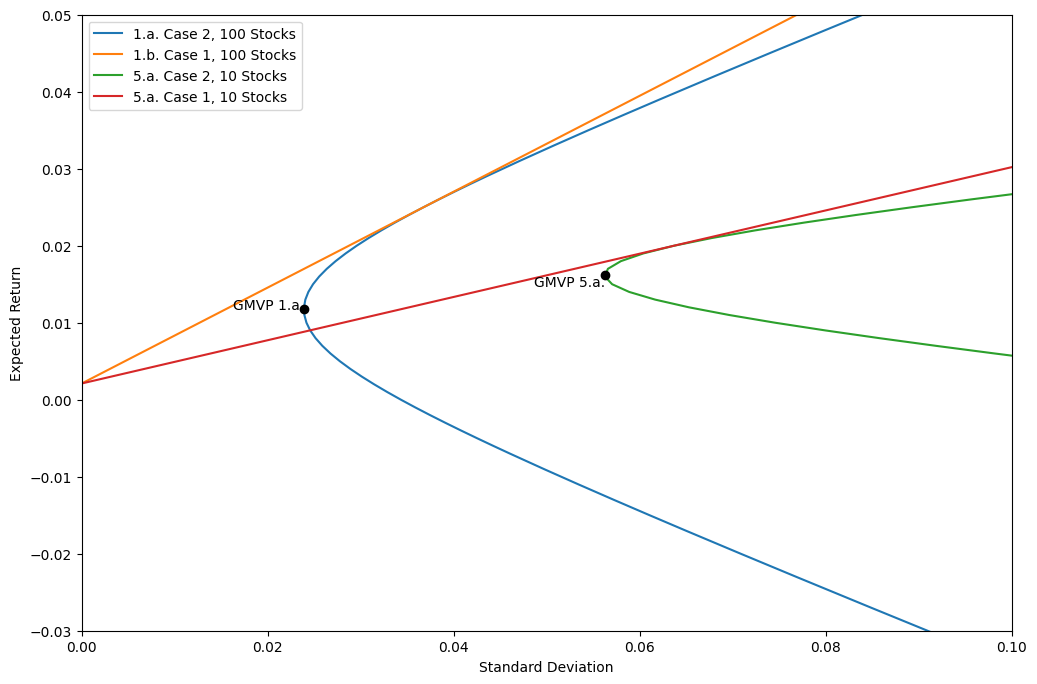

In [106]:
## fig

fig, ax = plt.subplots(1,1,figsize=(12,8))

ans1a.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans2a.plot(x='port_std', y='port_ret', ax=ax, legend=False)

ans5a_case2.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans5a_case1.plot(x='port_std', y='port_ret', ax=ax, legend=False)

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.set_xlim(0,0.10)
ax.set_ylim(-0.03,0.05)

ax.set_xlim(0)

w_gmvp5a = inv5a.dot(ones5a)/(ones5a.T.dot(inv5a).dot(ones5a))
w_gmvp5a.sum()

mu_gmvp5a = w_gmvp5a.T.dot(z5a)
std_gmvp5a = (w_gmvp5a.T.dot(sigma5a).dot(w_gmvp5a))**(0.5)

ax.plot(std_gmvp, mu_gmvp, 'o',color='black')
ax.text(std_gmvp, mu_gmvp, 'GMVP 1.a.',ha='right')

ax.plot(std_gmvp5a, mu_gmvp5a, 'o',color='black')
ax.text(std_gmvp5a, mu_gmvp5a, 'GMVP 5.a.',ha='right', va='top')


ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.set_xlim(0,0.10)
ax.set_ylim(-0.03,0.05)

ax.set_xlim(0)

w_gmvp5a = inv5a.dot(ones5a)/(ones5a.T.dot(inv5a).dot(ones5a))
w_gmvp5a.sum()

mu_gmvp5a = w_gmvp5a.T.dot(z5a)
std_gmvp5a = (w_gmvp5a.T.dot(sigma5a).dot(w_gmvp5a))**(0.5)

ax.legend(['1.a. Case 2, 100 Stocks', 
           '1.b. Case 1, 100 Stocks', 
           '5.a. Case 2, 10 Stocks',
           '5.a. Case 1, 10 Stocks'
          ])

## Sharpe

In [107]:
_, mu5a_case2, std5a_case2 = get_ans1a(mu_msp500, z5a, A5a, B5a, C5a, Delta5a, inv5a, sigma5a,ones5a)

In [108]:
_, mu5a_case1, std5a_case1 = get_ans2a(mu_msp500, z5a, A5a,B5a,C5a,rf_all,inv5a,sigma5a,ones5a,)

In [109]:
ans5a_sharpe_case2 = pd.DataFrame([[(mu5a_case2-rf_all)*12*100],
                             [std5a_case2*np.sqrt(12)*100],
                             [(mu5a_case2-rf_all)/std5a_case2*np.sqrt(12)],
                            ],
                            columns=['Optimal Portfolio (Case 2), 10 Stocks'],
                            index=['Excess Return (%)',
                                   'Volatility (%)',
                                   'Sharpe Ratio',
                                  ],
                           )

In [110]:
ans5a_sharpe_case1 = pd.DataFrame([[(mu5a_case1-rf_all)*12*100],
                             [std5a_case1*np.sqrt(12)*100],
                             [(mu5a_case1-rf_all)/std5a_case1*np.sqrt(12)],
                            ],
                            columns=['Optimal Portfolio (Case 1), 10 Stocks'],
                            index=['Excess Return (%)',
                                   'Volatility (%)',
                                   'Sharpe Ratio',
                                  ],
                           )

In [111]:
ans_summary_stat['Optimal Portfolio (Case 2), 10 Stocks'] = ans5a_sharpe_case2['Optimal Portfolio (Case 2), 10 Stocks']

In [112]:
ans_summary_stat['Optimal Portfolio (Case 1), 10 Stocks'] = ans5a_sharpe_case1['Optimal Portfolio (Case 1), 10 Stocks']

In [113]:
ans_summary_stat[['S&P 500',
                  'Optimal Portfolio (Case 2)', 'Optimal Portfolio (Case 2), 10 Stocks', 
                  'Optimal Portfolio (Case 1)', 'Optimal Portfolio (Case 1), 10 Stocks', 
                  ]]

,S&P 500,Optimal Portfolio (Case 2),"Optimal Portfolio (Case 2), 10 Stocks",Optimal Portfolio (Case 1),"Optimal Portfolio (Case 1), 10 Stocks"
Excess Return (%),6.700256,6.700256,6.700256,6.700256,6.700256
Volatility (%),14.578627,8.784146,30.346874,3.106376,6.884828
Sharpe Ratio,0.459594,0.762767,0.220789,2.156936,0.973191


### More amount of stocks provides better diversification benefit.

## 5.b.

In [114]:
msf5b_money = msf[msf['flag_sector']==1].copy()
msf5b_divind = msf[msf['flag_sector']==0].copy()

In [115]:
z5b_money = msf5b_money.groupby(['permno'])['ret'].mean().values.reshape(-1,1)
z5b_divind = msf5b_divind.groupby(['permno'])['ret'].mean().values.reshape(-1,1)

### Covariance matrix

In [116]:
sigma5b_money, inv5b_money = get_cov_inv(msf5b_money)
sigma5b_divind, inv5b_divind = get_cov_inv(msf5b_divind)

### Vector of ones

In [117]:
nfirms5b_money = len(msf5b_money['permno'].unique())
ones5b_money = np.ones((nfirms5b_money,1))

In [118]:
nfirms5b_divind = len(msf5b_divind['permno'].unique())
ones5b_divind = np.ones((nfirms5b_divind,1))

In [119]:
A5b_money, B5b_money, C5b_money, Delta5b_money = get_parameters(ones5b_money, inv5b_money, z5b_money)

In [120]:
A5b_divind, B5b_divind, C5b_divind, Delta5b_divind = get_parameters(ones5b_divind, inv5b_divind, z5b_divind)

In [121]:
step = 0.001 # 10bp

min_ret = -0.1 # multiply 100 to get a percent unit.
max_ret = 0.1

list_ans5b_money_case2 = []
list_ans5b_money_case1 = []
for mu_p in np.arange(min_ret,max_ret+step,step):
    
    _, mu_port5b_money_case2, std_port5b_money_case2 = get_ans1a(mu_p, z5b_money, A5b_money, B5b_money, C5b_money, Delta5b_money, inv5b_money, sigma5b_money,ones5b_money)
    tmp_ans5b_money_case2 = pd.DataFrame([[mu_port5b_money_case2, std_port5b_money_case2]],columns=['port_ret', 'port_std'])
    list_ans5b_money_case2.append(tmp_ans5b_money_case2)
    
for mu_p in np.arange(rf_all,max_ret+step,step):
    
    _, mu_port5b_money_case1, std_port5b_money_case1 = get_ans2a(mu_p, z5b_money, A5b_money,B5b_money,C5b_money,rf_all,inv5b_money,sigma5b_money,ones5b_money,)
    tmp_ans5b_money_case1 = pd.DataFrame([[mu_port5b_money_case1, std_port5b_money_case1]],columns=['port_ret', 'port_std'])
    list_ans5b_money_case1.append(tmp_ans5b_money_case1)

In [122]:
step = 0.001 # 10bp

min_ret = -0.1 # multiply 100 to get a percent unit.
max_ret = 0.1

list_ans5b_divind_case2 = []
list_ans5b_divind_case1 = []
for mu_p in np.arange(min_ret,max_ret+step,step):
    
    _, mu_port5b_divind_case2, std_port5b_divind_case2 = get_ans1a(mu_p, z5b_divind, A5b_divind, B5b_divind, C5b_divind, Delta5b_divind, inv5b_divind, sigma5b_divind,ones5b_divind)
    tmp_ans5b_divind_case2 = pd.DataFrame([[mu_port5b_divind_case2, std_port5b_divind_case2]],columns=['port_ret', 'port_std'])
    list_ans5b_divind_case2.append(tmp_ans5b_divind_case2)
    
for mu_p in np.arange(rf_all,max_ret+step,step):
    
    _, mu_port5b_divind_case1, std_port5b_divind_case1 = get_ans2a(mu_p, z5b_divind, A5b_divind,B5b_divind,C5b_divind,rf_all,inv5b_divind,sigma5b_divind,ones5b_divind,)
    tmp_ans5b_divind_case1 = pd.DataFrame([[mu_port5b_divind_case1, std_port5b_divind_case1]],columns=['port_ret', 'port_std'])
    list_ans5b_divind_case1.append(tmp_ans5b_divind_case1)

In [123]:
ans5b_money_case2 = pd.concat(list_ans5b_money_case2).reset_index(drop=True)
ans5b_money_case2.sort_values(['port_ret'],inplace=True)
ans5b_money_case2.reset_index(drop=True,inplace=True)

ans5b_money_case1 = pd.concat(list_ans5b_money_case1).reset_index(drop=True)
ans5b_money_case1.sort_values(['port_ret'],inplace=True)
ans5b_money_case1.reset_index(drop=True,inplace=True)

In [124]:
ans5b_divind_case2 = pd.concat(list_ans5b_divind_case2).reset_index(drop=True)
ans5b_divind_case2.sort_values(['port_ret'],inplace=True)
ans5b_divind_case2.reset_index(drop=True,inplace=True)

ans5b_divind_case1 = pd.concat(list_ans5b_divind_case1).reset_index(drop=True)
ans5b_divind_case1.sort_values(['port_ret'],inplace=True)
ans5b_divind_case1.reset_index(drop=True,inplace=True)

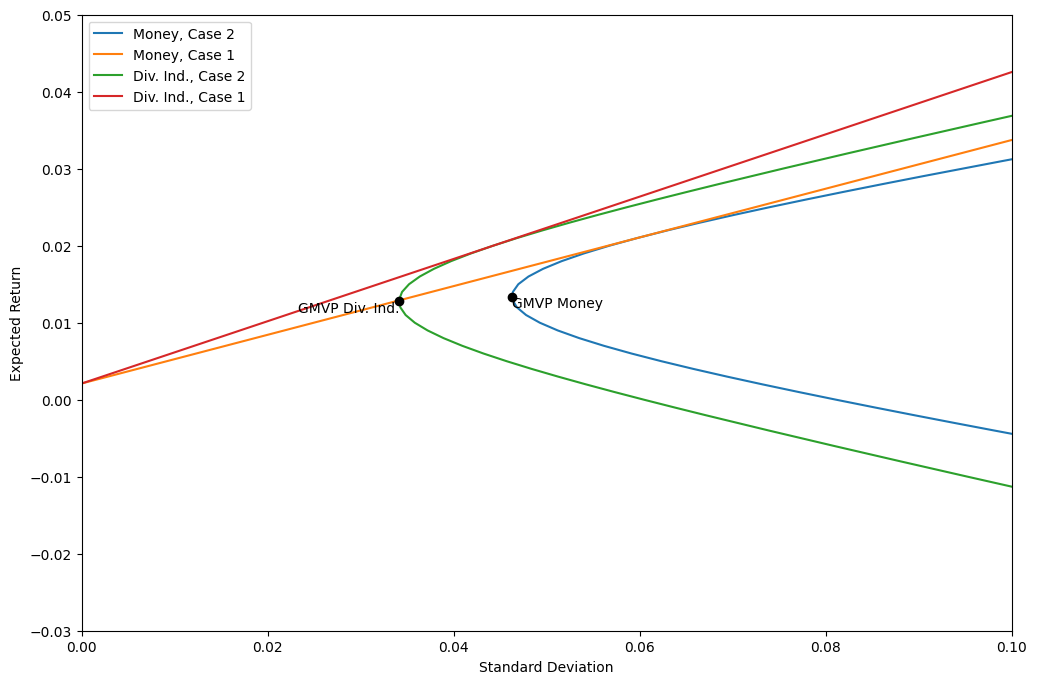

In [125]:
## fig

fig, ax = plt.subplots(1,1,figsize=(12,8))

ans5b_money_case2.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans5b_money_case1.plot(x='port_std', y='port_ret', ax=ax, legend=False)


ans5b_divind_case2.plot(x='port_std', y='port_ret', ax=ax, legend=False)
ans5b_divind_case1.plot(x='port_std', y='port_ret', ax=ax, legend=False)


ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.set_xlim(0,0.10)
ax.set_ylim(-0.03,0.05)

ax.set_xlim(0)

w_gmvp5b_money = inv5b_money.dot(ones5b_money)/(ones5b_money.T.dot(inv5b_money).dot(ones5b_money))
w_gmvp5b_money.sum()

mu_gmvp5b_money = w_gmvp5b_money.T.dot(z5b_money)
std_gmvp5b_money = (w_gmvp5b_money.T.dot(sigma5b_money).dot(w_gmvp5b_money))**(0.5)

w_gmvp5b_divind = inv5b_divind.dot(ones5b_divind)/(ones5b_divind.T.dot(inv5b_divind).dot(ones5b_divind))
w_gmvp5b_divind.sum()

mu_gmvp5b_divind = w_gmvp5b_divind.T.dot(z5b_divind)
std_gmvp5b_divind = (w_gmvp5b_divind.T.dot(sigma5b_divind).dot(w_gmvp5b_divind))**(0.5)

ax.plot(std_gmvp5b_money, mu_gmvp5b_money, 'o',color='black')
ax.text(std_gmvp5b_money, mu_gmvp5b_money, 'GMVP Money',ha='left', va='top')



ax.plot(std_gmvp5b_divind, mu_gmvp5b_divind, 'o',color='black')
ax.text(std_gmvp5b_divind, mu_gmvp5b_divind, 'GMVP Div. Ind.',ha='right',va='top')

ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Expected Return')

ax.set_xlim(0,0.10)
ax.set_ylim(-0.03,0.05)

ax.set_xlim(0)

w_gmvp5b_money = inv5b_money.dot(ones5b_money)/(ones5b_money.T.dot(inv5b_money).dot(ones5b_money))
w_gmvp5b_money.sum()

mu_gmvp5b_money = w_gmvp5b_money.T.dot(z5b_money)
std_gmvp5b_money = (w_gmvp5b_money.T.dot(sigma5b_money).dot(w_gmvp5b_money))**(0.5)

ax.legend(['Money, Case 2', 
           'Money, Case 1', 
           'Div. Ind., Case 2',
           'Div. Ind., Case 1',
          ])

## Sharpe

In [126]:
_, mu5b_money_case2, std5b_money_case2 = get_ans1a(mu_msp500, z5b_money, A5b_money, B5b_money, C5b_money, Delta5b_money, inv5b_money, sigma5b_money,ones5b_money)

In [127]:
_, mu5b_money_case1, std5b_money_case1 = get_ans2a(mu_msp500, z5b_money, A5b_money,B5b_money,C5b_money,rf_all,inv5b_money,sigma5b_money,ones5b_money,)

In [128]:
ans5b_money_sharpe_case2 = pd.DataFrame([[(mu5b_money_case2-rf_all)*12*100],
                             [std5b_money_case2*np.sqrt(12)*100],
                             [(mu5b_money_case2-rf_all)/std5b_money_case2*np.sqrt(12)],
                            ],
                            columns=['Optimal Portfolio (Case 2), Money'],
                            index=['Excess Return (%)',
                                   'Volatility (%)',
                                   'Sharpe Ratio',
                                  ],
                           )

In [129]:
ans5b_money_sharpe_case1 = pd.DataFrame([[(mu5b_money_case1-rf_all)*12*100],
                             [std5b_money_case1*np.sqrt(12)*100],
                             [(mu5b_money_case1-rf_all)/std5b_money_case1*np.sqrt(12)],
                            ],
                            columns=['Optimal Portfolio (Case 1), Money'],
                            index=['Excess Return (%)',
                                   'Volatility (%)',
                                   'Sharpe Ratio',
                                  ],
                           )

In [130]:
ans_summary_stat['Optimal Portfolio (Case 2), Money'] = ans5b_money_sharpe_case2['Optimal Portfolio (Case 2), Money']

In [131]:
ans_summary_stat['Optimal Portfolio (Case 1), Money'] = ans5b_money_sharpe_case1['Optimal Portfolio (Case 1), Money']

In [132]:
_, mu5b_divind_case2, std5b_divind_case2 = get_ans1a(mu_msp500, z5b_divind, A5b_divind, B5b_divind, C5b_divind, Delta5b_divind, inv5b_divind, sigma5b_divind,ones5b_divind)

In [133]:
_, mu5b_divind_case1, std5b_divind_case1 = get_ans2a(mu_msp500, z5b_divind, A5b_divind,B5b_divind,C5b_divind,rf_all,inv5b_divind,sigma5b_divind,ones5b_divind,)

In [134]:
ans5b_divind_sharpe_case2 = pd.DataFrame([[(mu5b_divind_case2-rf_all)*12*100],
                             [std5b_divind_case2*np.sqrt(12)*100],
                             [(mu5b_divind_case2-rf_all)/std5b_divind_case2*np.sqrt(12)],
                            ],
                            columns=['Optimal Portfolio (Case 2), Div. Ind.'],
                            index=['Excess Return (%)',
                                   'Volatility (%)',
                                   'Sharpe Ratio',
                                  ],
                           )

In [135]:
ans5b_divind_sharpe_case1 = pd.DataFrame([[(mu5b_divind_case1-rf_all)*12*100],
                             [std5b_divind_case1*np.sqrt(12)*100],
                             [(mu5b_divind_case1-rf_all)/std5b_divind_case1*np.sqrt(12)],
                            ],
                            columns=['Optimal Portfolio (Case 1), Div. Ind.'],
                            index=['Excess Return (%)',
                                   'Volatility (%)',
                                   'Sharpe Ratio',
                                  ],
                           )

In [136]:
ans_summary_stat['Optimal Portfolio (Case 2), Div. Ind.'] = ans5b_divind_sharpe_case2['Optimal Portfolio (Case 2), Div. Ind.']

In [137]:
ans_summary_stat['Optimal Portfolio (Case 1), Div. Ind.'] = ans5b_divind_sharpe_case1['Optimal Portfolio (Case 1), Div. Ind.']

In [138]:
ans_summary_stat[['S&P 500',
                  'Optimal Portfolio (Case 2), Money', 'Optimal Portfolio (Case 2), Div. Ind.', 
                  'Optimal Portfolio (Case 1), Money', 'Optimal Portfolio (Case 1), Div. Ind.', 
                  ]]

,S&P 500,"Optimal Portfolio (Case 2), Money","Optimal Portfolio (Case 2), Div. Ind.","Optimal Portfolio (Case 1), Money","Optimal Portfolio (Case 1), Div. Ind."
Excess Return (%),6.700256,6.700256,6.700256,6.700256,6.700256
Volatility (%),14.578627,18.805325,13.684340,6.117279,4.782454
Sharpe Ratio,0.459594,0.356296,0.489629,1.095300,1.401008


### Diversed industry gives better risk-return profile.